In [94]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, zeros, vstack, squeeze, zeros_like, where, round
from src.plots import plot_vae_training_result, plot_image
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.exq_net_v1 import ExquisiteNetV1

device = device('cuda' if cuda.is_available() else 'cpu')

In [87]:
num_data = 60000

training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:num_data]
labels = training_data.targets[:num_data]

print(training_data.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10


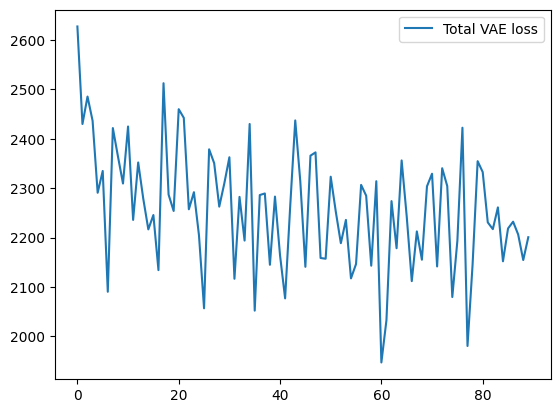

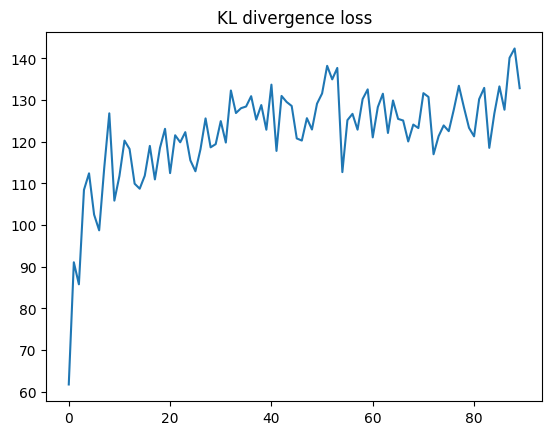

In [89]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 64
epoch = 10
learning_rate = 0.01

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

In [90]:
# images = vae.generate_data(n_samples=1, target_label=0)
# print(images.shape)
# print(images[0])
# print(images[0].max().item())
# print(images[0].min().item())

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Byte

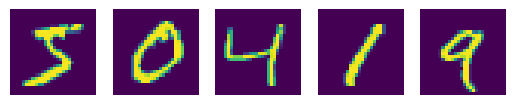

In [91]:
plot_image(training_data.data[:5] / 1.0)
print(training_data.data[:1000].mean().item())

torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   2,
            4,   5,   4,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   6,  25,  52,
           72,  83,  77,  50,  28,  13,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   6,  28,  78, 120,
          145, 155, 150, 128,  90,  51,  18,   4,   0,   0,   0,   

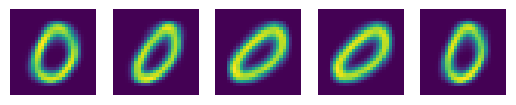

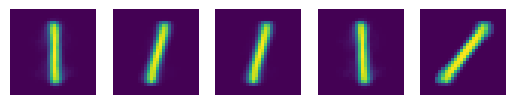

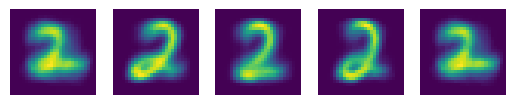

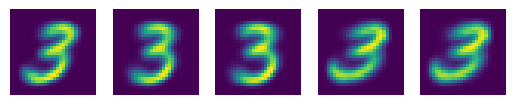

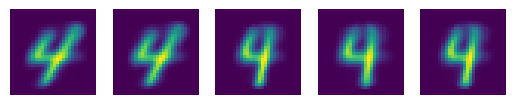

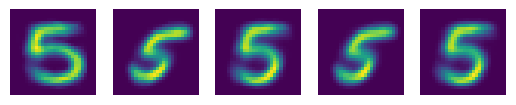

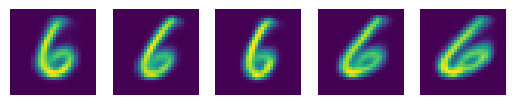

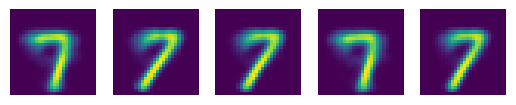

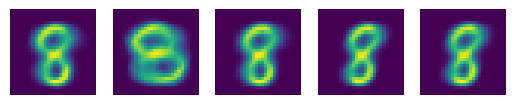

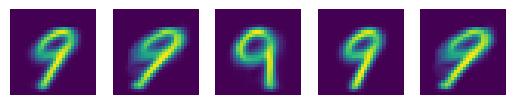

In [112]:
# train classifier on generated images
data_count = 60000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

global_model = vae
            
for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    output = global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach()

    output = where(output < 5e-03, zeros_like(output), output)
    output = output * 200
    output = output.int()
    plot_image(output[:5])
    images.append(output)
    
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())
final_images = vstack(images)
final_labels = vstack(labels)

training_data.data = squeeze(final_images, dim=1)
training_data.targets = final_labels.argmax(dim=1)

print(training_data.data.shape)
print(training_data.targets.shape)
print(training_data.data[:1])

In [113]:
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=False, download=True,
                                                  transform=torchvision.transforms.ToTensor())

In [114]:
batch_size = 64
epoch = 5
learning_rate = 0.01

classifier = ExquisiteNetV1(class_num=10, img_channels=1)
classifier.to(device)
classifier.train_model(training_data, testing_data, batch_size=batch_size, learning_rate=learning_rate, epochs=epoch)

Epoch done:  1
Training loss:  0.03873984143137932
Testing loss:  -0.0862431706872525
Epoch done:  2
Training loss:  0.13122276961803436
Testing loss:  -0.16002445509597957
Epoch done:  3
Training loss:  0.003917854744940996
Testing loss:  -0.14398017319239628
Epoch done:  4
Training loss:  0.001159316161647439
Testing loss:  -0.1604124455161061
Epoch done:  5
Training loss:  0.0007662755087949336
Testing loss:  -0.1373090175496545


In [115]:
# test on real data
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=False, download=True,
                                                  transform=torchvision.transforms.ToTensor())

accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)
print("Test on real data")
print(accuracy)
print(loss)
print(f1_macro)
print(f1_micro)
print("")


# test on synthetic data
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []
for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    output = global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach()

    output = where(output < 5e-03, zeros_like(output), output)
    output = output * 200
    output = output.int()
    images.append(output)
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())
final_images = vstack(images)
final_labels = vstack(labels)

testing_data.data = squeeze(final_images, dim=1)
testing_data.targets = final_labels.argmax(dim=1)

accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)

print("Test on synthetic data")
print(accuracy)
print(loss)
print(f1_macro)
print(f1_micro)

Test on real data
0.0853
-0.14647239565279843
0.08159613949866015
0.0853

Test on synthetic data
1.0
-11.361207737284861
1.0
1.0
